In [ ]:
pip install yfinance pandas numpy matplotlib seaborn scikit-learn PyPortfolioOpt

In [ ]:
import yfinance as yf
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Fetch data
tickers = ["GLD", "SLV", "USO", "UNG", "DBA", "CPER"]
data = yf.download(tickers, start="2022-01-01", end="2024-01-01", auto_adjust=False)
adj_close = data['Adj Close']
returns = adj_close.pct_change().dropna()


[*********************100%***********************]  6 of 6 completed


In [ ]:
# Portfolio Optimization
mu = mean_historical_return(adj_close)
S = sample_cov(adj_close)
ef = EfficientFrontier(mu, S, weight_bounds=(0.05, 0.6))
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
expected_return, volatility, sharpe_ratio = ef.portfolio_performance()


In [ ]:
# PCA
pca = PCA()
pca.fit(returns)
explained_variance = pca.explained_variance_ratio_
components = pd.DataFrame(pca.components_, columns=returns.columns)
components.index = [f"PC{i+1}" for i in range(components.shape[0])]
factor_returns = returns.dot(components.T)

In [ ]:
# Download ETF data
sector_etfs = ["DBC", "COMT", "GSG", "PDBC", "USCI", "BCI"]
etf_data = yf.download(sector_etfs, start='2022-01-01', end='2024-01-01', auto_adjust=True)['Close']
etf_returns = etf_data.pct_change().dropna()
aligned_factors, aligned_etfs = factor_returns.align(etf_returns, join='inner', axis=0)

[*********************100%***********************]  6 of 6 completed


In [ ]:
# Correlation Grid
correlation_grid = pd.DataFrame(index=aligned_factors.columns, columns=aligned_etfs.columns)
for pc in aligned_factors.columns:
    for etf in aligned_etfs.columns:
        correlation_grid.loc[pc, etf] = aligned_factors[pc].corr(aligned_etfs[etf])
subset_correlation_grid = correlation_grid.iloc[:4, :]

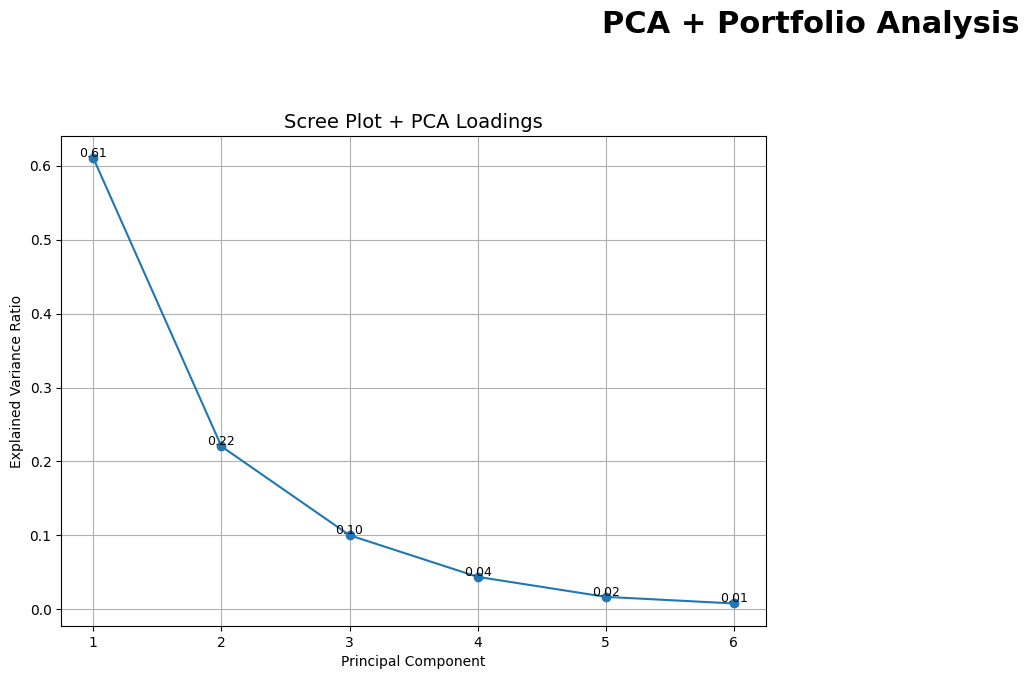

In [ ]:
# Create Figure Grid
fig = plt.figure(figsize=(20, 14))
fig.suptitle("PCA + Portfolio Analysis", fontsize=22, weight='bold', y=0.97)

# Scree Plot (top left)
ax1 = fig.add_subplot(2, 2, 1)
x = range(1, len(explained_variance) + 1)
ax1.plot(x, explained_variance, marker='o')
for i, val in enumerate(explained_variance):
    ax1.text(x[i], val + 0.002, f"{val:.2f}", ha='center', fontsize=9)
ax1.set_title("Scree Plot + PCA Loadings", fontsize=14)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.grid(True)

/tmp/ipython-input-60-197725768.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


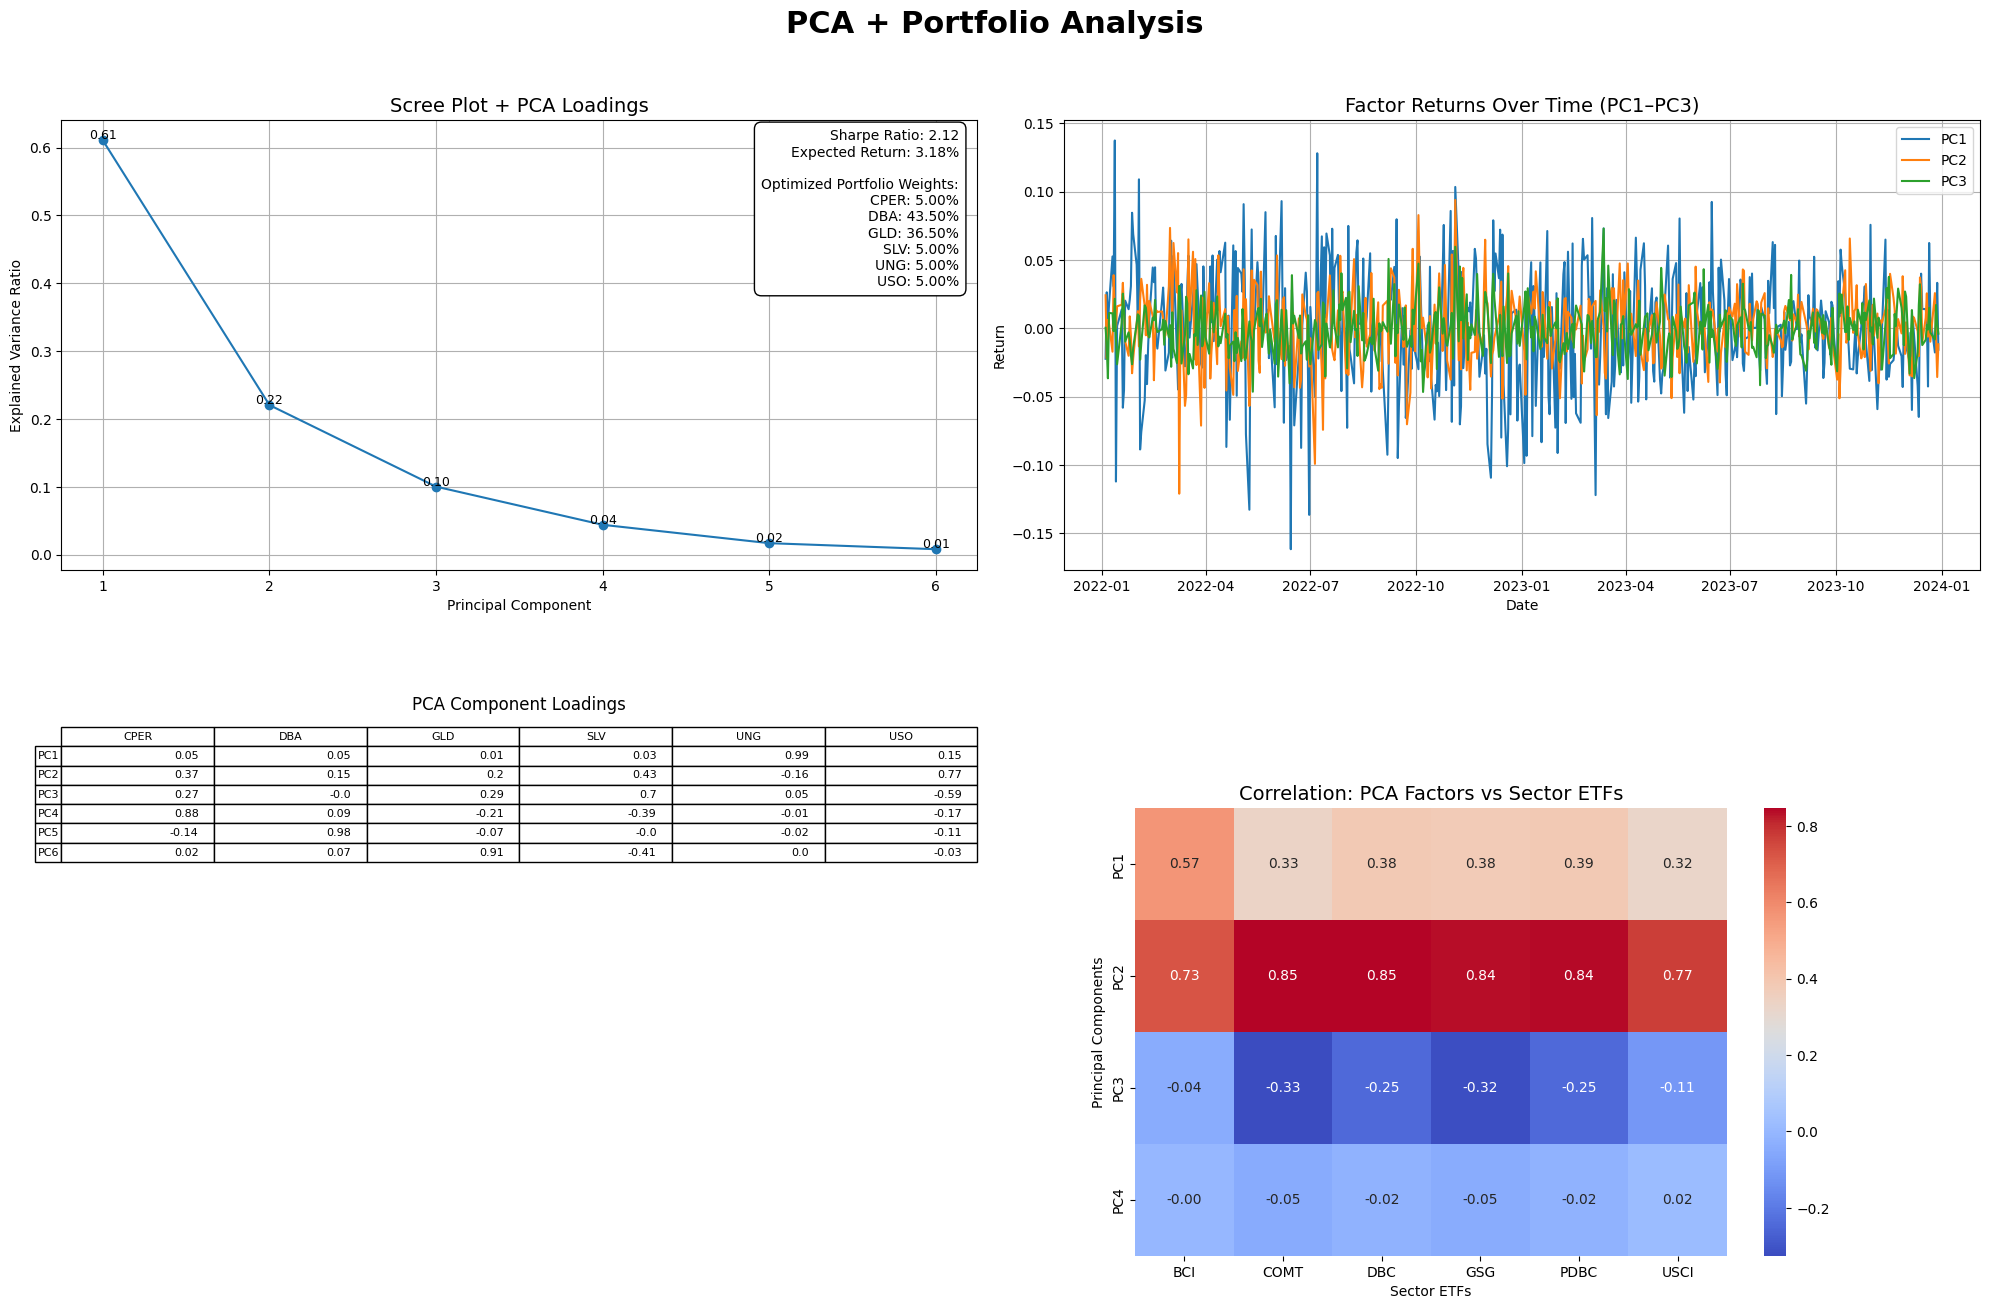

In [ ]:
# Create Figure Grid
fig = plt.figure(figsize=(20, 14))
fig.suptitle("PCA + Portfolio Analysis", fontsize=22, weight='bold', y=0.97)

# Scree Plot (top left)
ax1 = fig.add_subplot(2, 2, 1)
x = range(1, len(explained_variance) + 1)
ax1.plot(x, explained_variance, marker='o')
for i, val in enumerate(explained_variance):
    ax1.text(x[i], val + 0.002, f"{val:.2f}", ha='center', fontsize=9)
ax1.set_title("Scree Plot + PCA Loadings", fontsize=14)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.grid(True)

# Portfolio summary (top right inside ax1)
summary_text = (
    f"Sharpe Ratio: {sharpe_ratio:.2f}\n"
    f"Expected Return: {expected_return:.2%}\n\n"
    "Optimized Portfolio Weights:\n" +
    "\n".join([f"{k}: {v:.2%}" for k, v in cleaned_weights.items()])
)
ax1.text(0.98, 0.98, summary_text, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Table (right below scree plot)
table_data = components.round(2).values
col_labels = components.columns.tolist()
row_labels = components.index.tolist()

# Add table
table = ax1.table(cellText=table_data,
                  colLabels=col_labels,
                  rowLabels=row_labels,
                  loc='bottom',
                  bbox=[0, -0.65, 1, 0.3])  # Adjust height to leave space for title
table.auto_set_font_size(False)
table.set_fontsize(8)

# Add title for the table inside the same axis (ax1)
ax1.text(0.5, -0.3, "PCA Component Loadings", fontsize=12,
         ha='center', va='center', transform=ax1.transAxes)



# Factor Returns Over Time (top right)
ax2 = fig.add_subplot(2, 2, 2)
for i in range(min(3, factor_returns.shape[1])):
    ax2.plot(factor_returns.index, factor_returns.iloc[:, i], label=f'PC{i+1}')
ax2.set_title("Factor Returns Over Time (PC1–PC3)", fontsize=14)
ax2.set_xlabel("Date")
ax2.set_ylabel("Return")
ax2.legend()
ax2.grid(True)


# Heatmap (bottom right)
ax4 = fig.add_axes([0.57, 0.08, 0.37, 0.32])  # [left, bottom, width, height]
sns.heatmap(subset_correlation_grid.astype(float), annot=True, cmap='coolwarm', fmt=".2f", ax=ax4)
ax4.set_title("Correlation: PCA Factors vs Sector ETFs", fontsize=14)
ax4.set_ylabel("Principal Components")
ax4.set_xlabel("Sector ETFs")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Create a list of selected tickers and weights from optimized portfolio
tickers_selected = [ticker for ticker, weight in cleaned_weights.items() if weight > 0]
weights_array = [cleaned_weights[ticker] for ticker in tickers_selected]

# Download price data for backtest period
test_data = yf.download(tickers_selected, start="2024-01-01", end="2025-01-01", auto_adjust=True)['Close']
test_returns = test_data.pct_change().dropna()

# Calculate daily portfolio returns using fixed weights
import numpy as np
portfolio_returns = test_returns.dot(weights_array)

# Calculate performance metrics
cumulative_return = (1 + portfolio_returns).prod() - 1
annualized_return = portfolio_returns.mean() * 252
annualized_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

# Print results
print("Backtest Performance (2024-01-01 to 2025-01-01):")
print(f"Cumulative Return: {cumulative_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


[*********************100%***********************]  6 of 6 completed

Backtest Performance (2024-01-01 to 2025-01-01):
Cumulative Return: 27.21%
Annualized Return: 24.86%
Annualized Volatility: 11.73%
Sharpe Ratio: 2.12


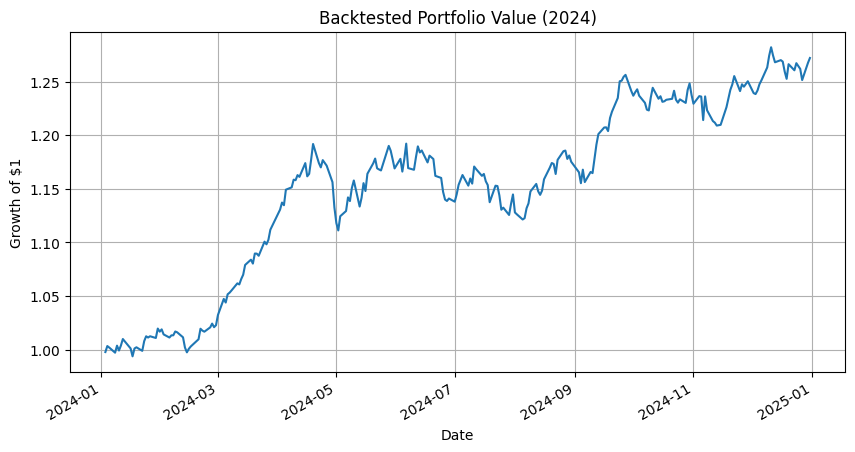

In [ ]:
import matplotlib.pyplot as plt

portfolio_value = (1 + portfolio_returns).cumprod()
portfolio_value.plot(figsize=(10, 5), title="Backtested Portfolio Value (2024)")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.grid(True)
plt.show()